# AI Traffic System Recognition System

In this project, I developed an AI-powered traffic sign recognition system using Convolutional Neural Networks (CNNs) to classify images of traffic signs into one of 43 categories. The model is trained on the German Traffic Sign Recognition Benchmark (GTSRB) dataset. The system is built using TensorFlow and utilizes a CNN architecture consisting of multiple convolutional layers, followed by pooling, fully connected layers, and dropout to enhance generalization. The model is trained on labeled images from the GTSRB dataset, and it achieves high accuracy on both the training and test data. Additionally, I have implemented a user-friendly interface that allows users to upload their own images of traffic signs for classification. This feature is powered by Gradio.

## Necessary Packages

In [1]:
!pip install ipywidgets tensorflow opencv-python-headless pandas numpy matplotlib scikit-learn seaborn kaggle

In [2]:
# Importing the packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

import cv2

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

import random

import gradio as gr

import zipfile
import os

2024-09-10 13:12:01.561086: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-10 13:12:01.563415: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-10 13:12:01.568238: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-10 13:12:01.580269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 13:12:01.597383: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

## Data Loading and Preprocessing

I found the GTSRB on Kaggle. Using Kaggle API, I download the data into the notebook using the following shell command.

In [6]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
gtsrb-german-traffic-sign.zip: Skipping, found more recently modified local copy (use --force to force download)


Next, the data is extracted from the zip file:

In [8]:
zip_path = 'gtsrb-german-traffic-sign.zip'
extract_to = 'data'

# Create the directory
os.makedirs(extract_to, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction Done")

Extraction Done


To use the data, I label and resize the test and training images. Note, the lables for the test images must be read in from the Test.csv file

In [9]:
# Define image dimensions (e.g., 32x32)
img_width, img_height = 32, 32

def load_images_and_labels(base_path):
    images = []
    labels = []
    num_classes = 43  # There are 43 classes of traffic signs in the GTSRB dataset

    for folder in range(num_classes):
        path = os.path.join(base_path, str(folder))
        if not os.path.exists(path):
            continue
        for file in os.listdir(path):
            image_path = os.path.join(path, file)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (img_width, img_height))
            images.append(image)
            labels.append(folder)
    
    # Convert lists to numpy arrays and normalize image vectors
    images = np.array(images)
    images = images.astype('float32') / 255.0
    labels = np.array(labels)
    labels = to_categorical(labels, num_classes=num_classes)
    
    return images, labels

def load_test_images_and_labels(base_path, label_file):
    # Load the labels from the CSV file
    label_df = pd.read_csv(label_file)
    images = []
    labels = []
    
    # Iterate over the dataframe rows
    for _, row in label_df.iterrows():
        image_path = os.path.join(base_path, row['Path'])
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.resize(image, (img_width, img_height))
            images.append(image)
            labels.append(row['ClassId'])
    
    # Convert lists to numpy arrays and normalize image vectors
    images = np.array(images)
    images = images.astype('float32') / 255.0
    labels = np.array(labels)
    # Convert labels to one-hot encoded format
    labels = to_categorical(labels, num_classes=43)
    
    return images, labels

# Extracting the dataset to 'data/train' and 'data/test'
train_images, train_labels = load_images_and_labels('data/train')
test_images, test_labels = load_test_images_and_labels('data', 'data/Test.csv')

print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")
print("Data Loaded and Processed")

Train images shape: (39209, 32, 32, 3)
Test images shape: (12630, 32, 32, 3)
Data Loaded and Processed


## Model Building

A CNN model for traffic sign classification is built using Keras's Sequential API. The model processes input images and categorizes them into one of 43 traffic sign classes. Using Sequential architecture, first there are three convolutional layers, each of which uses 3x3 filters to extract features from the images. These layers are followed by max-pooling layers to reduce the spatial dimensions of the feature maps for overfitting and to improve efficiency. A flattening layer is used to convert the 2D feature maps into a 1D vector, which can then be passed to a fully connected dense layer. The dense layer, consisting of 128 units, helps the model learn complex patterns from the feature maps. A dropout layer is added after this dense layer, which randomly drops 50% of the neurons during training to reduce overfitting. The final layer is a fully connected output layer with 43 units, one for each traffic sign category, and it uses the softmax activation function to produce probabilities for each class.

In [10]:
# Define the model architecture
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the convolutional layers to create a fully connected layer
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer (43 classes)
model.add(Dense(43, activation='softmax'))

# Print model summary
model.summary()

/home/dman4703/projects/AITrafficSignRecognition/env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,459 (642.42 KB)

 Trainable params: 164,459 (642.42 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Training

The model is trained using the training dataset (train_images and train_labels) for 15 epochs with a batch size of 32. During each epoch, the model adjusts its weights to minimize error, and its performance is evaluated on the validation dataset (test_images and test_labels) to monitor how well it generalizes to unseen data.

In [12]:
history = model.fit(train_images, train_labels, epochs=15, batch_size=32, validation_data=(test_images, test_labels))

Epoch 1/15
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.3281 - loss: 2.4821 - val_accuracy: 0.8733 - val_loss: 0.4313
Epoch 2/15
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.8849 - loss: 0.3770 - val_accuracy: 0.9275 - val_loss: 0.2616
Epoch 3/15
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9477 - loss: 0.1687 - val_accuracy: 0.9451 - val_loss: 0.2198
Epoch 4/15
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9674 - loss: 0.1098 - val_accuracy: 0.9420 - val_loss: 0.2464
Epoch 5/15
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9754 - loss: 0.0836 - val_accuracy: 0.9533 - val_loss: 0.2010
Epoch 6/15
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9770 - loss: 0.0735 - val_accuracy: 0.9525 - val_loss: 0.2119
Epoch 7/15
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9834 - loss: 0.0516 - val_accuracy: 0.9575 - val_loss: 0.1848
Epoch 8/15
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9858 -

In [14]:
model.save('traffic_sign_model.keras')

## Model Evaluation

### Accuracy and Loss

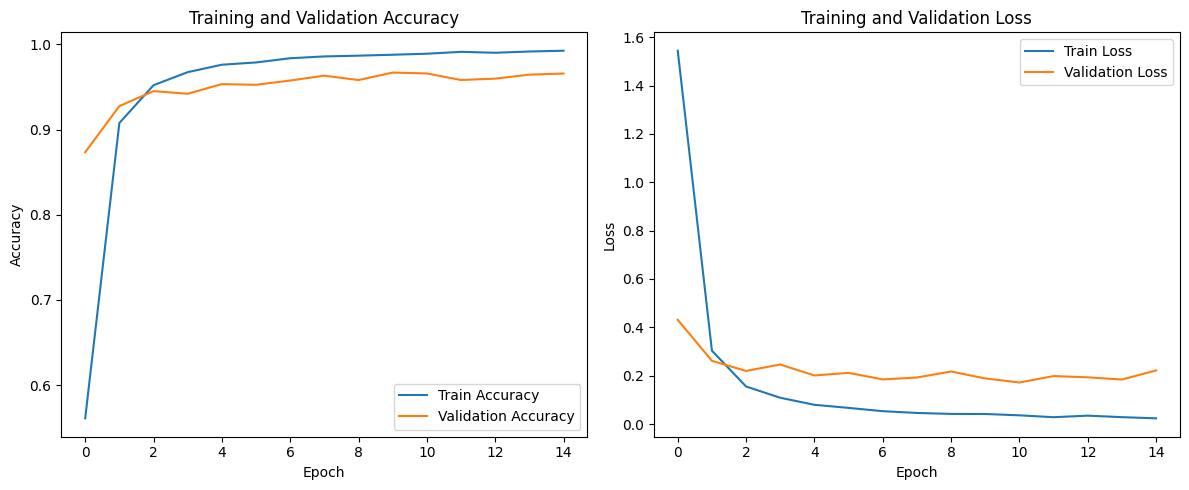

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training accuracy and validation accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.legend(loc='lower right')

# Plot training loss and validation loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss')
ax2.legend(loc='upper right')

# Display the plots
plt.tight_layout()
plt.show()

There is an upward trend in validation and train accuracy. This suggests that the model is generalizing well to unseen data and not merely memorizing the training examples. There is a downward trend in train loss, and a weaker downward trend in the validation loss, which has fluctuation. It might suggest overfitting.

In [16]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc * 100:.2f}%")


395/395 - 2s - 5ms/step - accuracy: 0.9657 - loss: 0.2218
Test accuracy: 96.57%


### Confusion Matrix

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


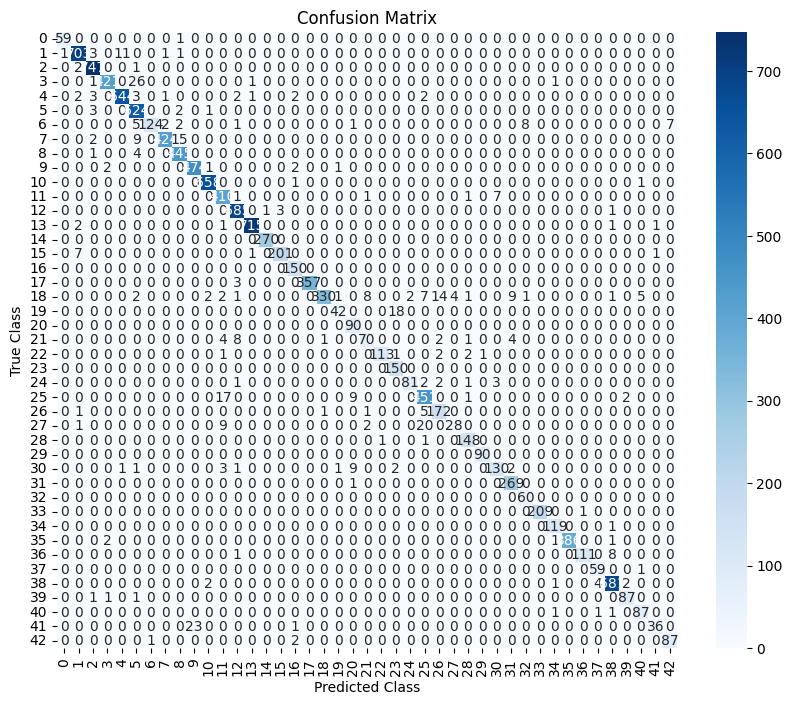

In [17]:
# Get predictions from the model
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot to class labels
y_true = np.argmax(test_labels, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

There is a clear diagonal in the confusion matrix - the strong trend and accuracy shows the model performs well.

### Classification Report

In [18]:
# Generate classification report
class_report = classification_report(y_true, y_pred_classes, target_names=[str(i) for i in range(43)])

# Display the classification report in text format
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        60
           1       0.98      0.98      0.98       720
           2       0.98      1.00      0.99       750
           3       0.99      0.94      0.96       450
           4       0.98      0.98      0.98       660
           5       0.92      0.99      0.96       630
           6       0.99      0.83      0.90       150
           7       0.99      0.94      0.97       450
           8       0.95      0.99      0.97       450
           9       0.95      0.99      0.97       480
          10       0.99      1.00      0.99       660
          11       0.92      0.98      0.95       420
          12       0.97      0.99      0.98       690
          13       1.00      0.99      0.99       720
          14       1.00      1.00      1.00       270
          15       0.99      0.96      0.97       210
          16       0.95      1.00      0.97       150
    

The classification report reveals that the model achieves an overall accuracy of 96% on the test dataset, demonstrating strong performance across most of the 43 traffic sign classes. The weighted averages, accounting for the varying support per class, are all around 0.96, suggesting that the model performs particularly well on more common traffic signs. High-performing classes such as class 1, class 2, class 10, and class 13 exhibit near-perfect metrics, with F1-scores of 0.98 or higher, indicating that the model is highly accurate at identifying these signs. However, classes like 21 and 27 show relatively lower F1-scores, with values of 0.81 and 0.61, suggesting that the model struggles with certain traffic signs, likely due to limited data or higher classification difficulty. 

### Misclassified Images

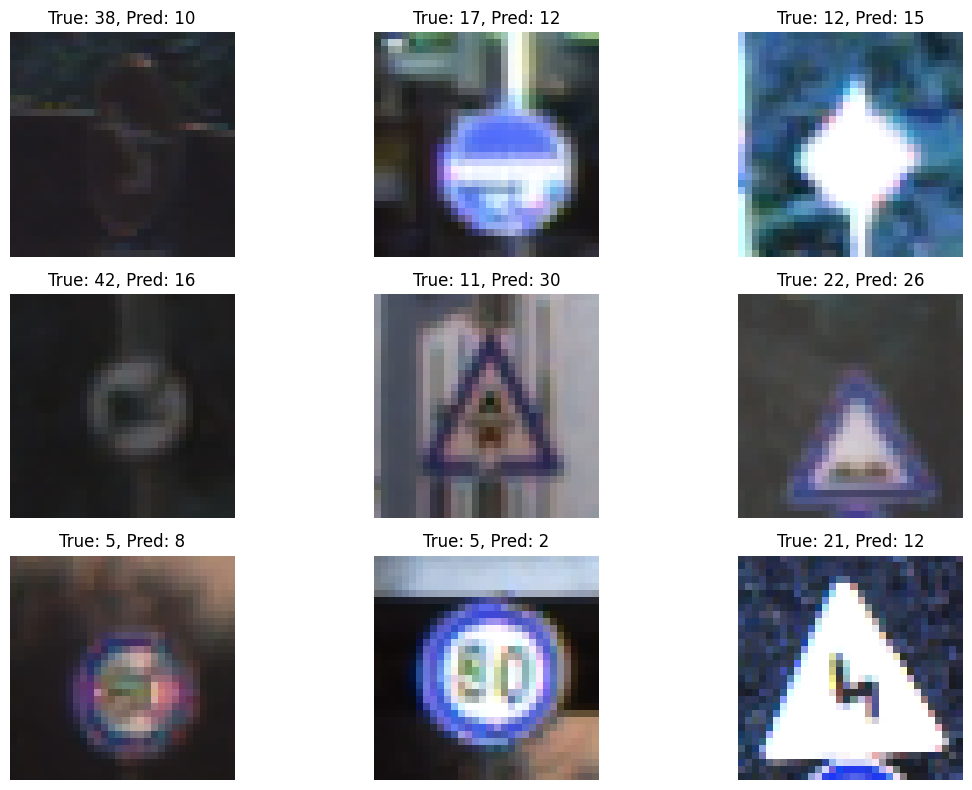

In [19]:
# Identify misclassified examples
misclassified_indices = np.where(y_pred_classes != y_true)[0]

# Shuffle the misclassified indices to get a random selection
random.shuffle(misclassified_indices)

# Plot a variety of misclassified images (you can change the number to display more or fewer images)
plt.figure(figsize=(12, 8))
num_samples = 9  # Display 9 misclassified images
for i, idx in enumerate(misclassified_indices[:num_samples]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[idx])
    plt.title(f'True: {y_true[idx]}, Pred: {y_pred_classes[idx]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Next Steps

Implementing data augmentation techniques such as rotating, scaling, or flipping the images could help the model generalize better by providing more diverse training examples. Additionally, hyperparameter tuning could be explored by adjusting the learning rate, batch size, or number of epochs to optimize training. In addition, increasing the dataset size could enhance the model's ability to recognize more challenging traffic signs

## Predictions

In the following section, independent photos can be uploaded to be predicted by the model, using the upload button below.

In [3]:
model = load_model('traffic_sign_model.keras')
#Function to preprocess the uploaded image and make a prediction
def predict_traffic_sign(image):
    # Resize the image to 32x32 (the input shape of the model)
    image = cv2.resize(image, (32, 32))
    image = image.astype('float32') / 255.0  # Normalize pixel values
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    
    # Make a prediction using the pre-trained model
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction, axis=1)[0]  # Get the predicted class index
    
    # Map the predicted class index to the corresponding traffic sign label
    class_labels = [
    'Speed limit (20km/h)',       # 0
    'Speed limit (30km/h)',       # 1
    'Speed limit (50km/h)',       # 2
    'Speed limit (60km/h)',       # 3
    'Speed limit (70km/h)',       # 4
    'Speed limit (80km/h)',       # 5
    'End of speed limit (80km/h)', # 6
    'Speed limit (100km/h)',      # 7
    'Speed limit (120km/h)',      # 8
    'No passing',                 # 9
    'No passing for vehicles over 3.5 metric tons', # 10
    'Right-of-way at the next intersection',        # 11
    'Priority road',              # 12
    'Yield',                      # 13
    'Stop',                       # 14
    'No vehicles',                # 15
    'Vehicles over 3.5 metric tons prohibited',     # 16
    'No entry',                   # 17
    'General caution',            # 18
    'Dangerous curve to the left',# 19
    'Dangerous curve to the right',# 20
    'Double curve',               # 21
    'Bumpy road',                 # 22
    'Slippery road',              # 23
    'Road narrows on the right',  # 24
    'Road work',                  # 25
    'Traffic signals',            # 26
    'Pedestrians',                # 27
    'Children crossing',          # 28
    'Bicycles crossing',          # 29
    'Beware of ice/snow',         # 30
    'Wild animals crossing',      # 31
    'End of all speed and passing limits',          # 32
    'Turn right ahead',           # 33
    'Turn left ahead',            # 34
    'Ahead only',                 # 35
    'Go straight or right',       # 36
    'Go straight or left',        # 37
    'Keep right',                 # 38
    'Keep left',                  # 39
    'Roundabout mandatory',       # 40
    'End of no passing',          # 41
    'End of no passing by vehicles over 3.5 metric tons' # 42
    ]
    
    # Return the corresponding label for the predicted class
    return class_labels[predicted_class]

# Create the Gradio interface
interface = gr.Interface(
    fn=predict_traffic_sign,  # Function to be called for predictions
    inputs=gr.Image(),  # Removed the shape argument
    outputs=gr.Textbox(),  # Textbox to display the prediction
    title="Traffic Sign Classifier",  # Title of the interface
    description="Upload an image of a traffic sign, and the model will predict its class."
)

# Launch the Gradio interface
interface.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
